# Core Workflow: Applying Model
Load existing, trained model from file and apply it to imagery (and other inputs) in order to generate a comprehensive LULC raster covering the entire urban extent of a given city. Allows user to preview LULC tiles and compare against VIR component of input stack.  
  
Date: 2018-09-17  
Author: Peter Kerins

### Import statements
(may be over-inclusive)

In [1]:
# typical, comprehensive imports
import warnings
warnings.filterwarnings('ignore')
#
import os
import sys
import json
import itertools
import pickle
from pprint import pprint
#
import numpy as np
import shapely
import cartopy
import geojson
import fiona
import gdal
import h5py
get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler 
import ogr, gdal
from keras.models import load_model
import math
from keras.utils import to_categorical
from keras.models import load_model
from keras import models
from keras import layers
from keras.layers import Dropout
from keras.utils import to_categorical
from skimage import measure
from skimage import filters
from scipy import stats

import tensorflow as tf
import keras

import collections

import descarteslabs as dl
print dl.places.find('illinois') ## TEST

# how do change this from manual?
sys.path.append('/home/Peter.Kerins/UrbanLandUse/utils')
print sys.path

import util_descartes
import util_ml
import util_rasters
import util_vectors
import util_workflow


Using TensorFlow backend.


[{u'name': u'Illinois', u'id': 85688697, u'placetype': u'region', u'bbox': [-91.512974, 36.970298, -87.019935, 42.508302], u'path': u'continent:north-america_country:united-states_region:illinois', u'slug': u'north-america_united-states_illinois'}]
['', '/usr/lib/python2.7', '/usr/lib/python2.7/plat-x86_64-linux-gnu', '/usr/lib/python2.7/lib-tk', '/usr/lib/python2.7/lib-old', '/usr/lib/python2.7/lib-dynload', '/home/Peter.Kerins/.local/lib/python2.7/site-packages', '/usr/local/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages/PILcompat', '/usr/lib/python2.7/dist-packages/gtk-2.0', '/usr/local/lib/python2.7/dist-packages/IPython/extensions', '/home/Peter.Kerins/.ipython', '/home/Peter.Kerins/UrbanLandUse/utils']


### Set key variables

In [2]:
place = 'sitapur'

data_root='/data/steven/data/'
data_path=data_root+place+'/'

bands=['blue','green','red','nir','swir1','swir2','alpha']; suffix='BGRNS1S2A'  # S2, Lx
resolution=10  # Lx:15 S2:10

s1_bands=['vv','vh']; s1_suffix='VVVH'
s1_resolution = resolution

tile_resolution = resolution
tile_size = 256
tile_pad = 8

categories = [0,1,4,6]

# NYU AoUE land use/land cover categories
category_label = {0:'Open Space',1:'Non-Residential',\
                   2:'Residential Atomistic',3:'Residential Informal Subdivision',\
                   4:'Residential Formal Subdivision',5:'Residential Housing Project',\
                   6:'Roads',7:'Study Area',8:'Labeled Study Area',254:'No Data',255:'No Label'}

### Load and inspect study area

sitapur Sitapur
>>> ogrinfo -al -so /data/steven/data/sitapur/Sitapur_studyArea.shp
INFO: Open of `/data/steven/data/sitapur/Sitapur_studyArea.shp'
      using driver `ESRI Shapefile' successful.

Layer name: Sitapur_studyArea
Metadata:
  DBF_DATE_LAST_UPDATE=2016-07-18
Geometry: Polygon
Feature Count: 1
Extent: (452962.901712, 3030448.248706) - (484367.511519, 3076769.642552)
Layer SRS WKT:
PROJCS["WGS_1984_UTM_Zone_44N",
    GEOGCS["GCS_WGS_1984",
        DATUM["WGS_1984",
            SPHEROID["WGS_84",6378137.0,298.257223563]],
        PRIMEM["Greenwich",0.0],
        UNIT["Degree",0.0174532925199433]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["false_easting",500000.0],
    PARAMETER["false_northing",0.0],
    PARAMETER["central_meridian",81.0],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["latitude_of_origin",0.0],
    UNIT["Meter",1.0]]
Id: Integer (6.0)

>>> ogrinfo -al -so /data/steven/data/sitapur/Sitapur_studyAreaEPSG4326.shp
INFO: Open of `/data/steven/data

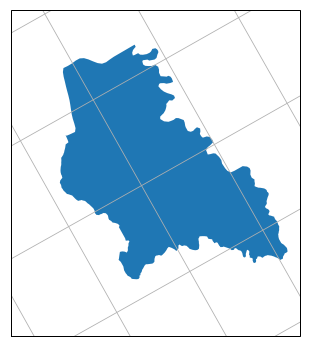

In [3]:
print place, place.title() # capitalized version of place name
place_title = place.title()
place_shapefile = data_path+place_title+"_studyAreaEPSG4326.shp"

util_vectors.info_studyareas(data_path, place)

shape = util_vectors.load_shape(place_shapefile)
polygon = shape['geometry']['coordinates']
#print polygon
#pprint(shape)
place_bbox = shape['bbox']
#print bbox

# using Albers projection
lonlat_crs = cartopy.crs.PlateCarree()
clat, clon = (place_bbox[0]+place_bbox[2])/2.0, (place_bbox[1]+place_bbox[3])/2.0
print "center co-ordinates", clat, clon
albers = cartopy.crs.AlbersEqualArea(central_latitude=clat, central_longitude=clon)

# visualize Study Region
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(projection=albers) # Specify projection of the map here
shp = shapely.geometry.shape(shape['geometry'])
ax.add_geometries([shp], lonlat_crs)
ax.set_extent((place_bbox[0], place_bbox[2], place_bbox[1], place_bbox[3]), crs=lonlat_crs)
ax.gridlines(crs=lonlat_crs)
plt.show()

### Generate tiles

number of tiles to cover region 164
[u'geometry', u'type', u'properties']
tile022 {u'type': u'Polygon', u'coordinates': [[[80.58452554952855, 27.493811245326476], [80.61206133747775, 27.493890725222546], [80.61197521086865, 27.518446163412445], [80.5844333100891, 27.518366600693632], [80.58452554952855, 27.493811245326476]]]}


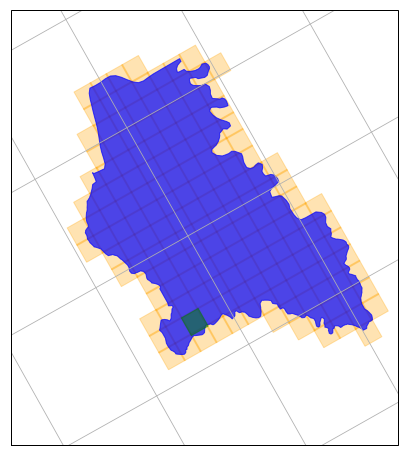

In [4]:
tiles = dl.raster.dltiles_from_shape(tile_resolution, tile_size, tile_pad, shape)
single_tile_id = 22
highlights = {single_tile_id:'green'}
util_vectors.draw_tiled_area(shape, tiles, albers, lonlat_crs, highlights=highlights)

### Set input stack and model parameters

In [5]:
window = 7    # width of square window

bands_vir=bands[:-1]
bands_sar=s1_bands
bands_ndvi=None
bands_ndbi=None
bands_osm=None

haze_removal = False

image_suffix = 'A'

model_id = 'workflow_demo_1'

In [6]:
stack_label, feature_count = util_workflow.build_stack_label(
        bands_vir=bands_vir,
        bands_sar=bands_sar,
        bands_ndvi=bands_ndvi,
        bands_ndbi=bands_ndbi,
        bands_osm=bands_osm,)
print stack_label, feature_count

vir+sar 8


### Load model objects

In [7]:
scaler_filename = data_root+model_id+'_scaler.pkl'
model_filename  = data_root+model_id+'_SVM.pkl'
network_filename = data_root+model_id+'_DLv3.hd5'

with open(scaler_filename, "rb") as f:
    scaler = pickle.load(f)
f.close()

with open(model_filename, "rb") as f:
    model = pickle.load(f)
f.close()

network = load_model(network_filename)

### Apply model to classify LULC

In [8]:
reload(util_workflow)
util_workflow.classify_tiles(data_path, place, tiles, image_suffix,
        window, stack_label, feature_count, model_id, scaler, network,
        bands_vir=bands_vir,
        bands_sar=bands_sar, bands_ndvi=None, bands_ndbi=None, bands_osm=None,
        haze_removal=False, categories=categories)

Feature count: 8
Stack label:  vir+sar
tile 0 load VIR image
vir shape: (7, 272, 272)
15206 study area within image
73984 full extent of image
vir band 0 into imn band 0 ( 0.0 - 0.1917 )
vir band 1 into imn band 1 ( 0.0 - 0.1987 )
vir band 2 into imn band 2 ( 0.0 - 0.2176 )
vir band 3 into imn band 3 ( 0.0 - 0.3653 )
vir band 4 into imn band 4 ( 0.0 - 0.3372 )
vir band 5 into imn band 5 ( 0.0 - 0.2899 )
tile 0 load SAR image
sar shape: (2, 272, 272)
sar band 0 into imn band 6 ( 0.0 - 1.0 )
sar band 1 into imn band 7 ( 0.0 - 1.0 )
imn (8, 272, 272) 8
imn.shape, Y.shape (8, 272, 272) (272, 272)
nz 65536
.....................done
0 64670
1 284
2 289
3 293
254 8448
/data/steven/data/sitapur/sitapur_tile000_workflow_demo_1_A_LULC.tif
Y_full sample [1. 0. 0. 0. 0. 1.]
tile 0 done
tile 1 load VIR image
vir shape: (7, 272, 272)
12687 study area within image
73984 full extent of image
vir band 0 into imn band 0 ( 0.0 - 0.1903 )
vir band 1 into imn band 1 ( 0.0 - 0.1765 )
vir band 2 into imn ban

.....................done
0 63788
1 869
2 238
3 641
254 8448
/data/steven/data/sitapur/sitapur_tile010_workflow_demo_1_A_LULC.tif
Y_full sample [9.8454916e-01 9.8979007e-03 1.2381062e-04 5.4290667e-03 0.0000000e+00
 9.8454916e-01]
tile 10 done
tile 11 load VIR image
vir shape: (7, 272, 272)
73984 study area within image
73984 full extent of image
vir band 0 into imn band 0 ( 0.1044 - 0.2371 )
vir band 1 into imn band 1 ( 0.08 - 0.2485 )
vir band 2 into imn band 2 ( 0.0523 - 0.2799 )
vir band 3 into imn band 3 ( 0.0541 - 0.4361 )
vir band 4 into imn band 4 ( 0.0287 - 0.3429 )
vir band 5 into imn band 5 ( 0.0147 - 0.3047 )
tile 11 load SAR image
sar shape: (2, 272, 272)
sar band 0 into imn band 6 ( 0.019607844 - 1.0 )
sar band 1 into imn band 7 ( 0.023529412 - 1.0 )
imn (8, 272, 272) 8
imn.shape, Y.shape (8, 272, 272) (272, 272)
nz 65536
.....................done
0 59787
1 1450
2 2037
3 2262
254 8448
/data/steven/data/sitapur/sitapur_tile011_workflow_demo_1_A_LULC.tif
Y_full sample [1.00

.....................done
0 64531
1 571
2 176
3 258
254 8448
/data/steven/data/sitapur/sitapur_tile021_workflow_demo_1_A_LULC.tif
Y_full sample [1. 0. 0. 0. 0. 1.]
tile 21 done
tile 22 load VIR image
vir shape: (7, 272, 272)
73067 study area within image
73984 full extent of image
vir band 0 into imn band 0 ( 0.0 - 0.3022 )
vir band 1 into imn band 1 ( 0.0 - 0.3194 )
vir band 2 into imn band 2 ( 0.0 - 0.2799 )
vir band 3 into imn band 3 ( 0.0 - 0.4166 )
vir band 4 into imn band 4 ( 0.0 - 0.3364 )
vir band 5 into imn band 5 ( 0.0 - 0.2809 )
tile 22 load SAR image
sar shape: (2, 272, 272)
sar band 0 into imn band 6 ( 0.0 - 1.0 )
sar band 1 into imn band 7 ( 0.0 - 1.0 )
imn (8, 272, 272) 8
imn.shape, Y.shape (8, 272, 272) (272, 272)
nz 65536
.....................done
0 60528
1 1760
2 1269
3 1979
254 8448
/data/steven/data/sitapur/sitapur_tile022_workflow_demo_1_A_LULC.tif
Y_full sample [1.0000000e+00 2.9728779e-16 1.3873531e-20 3.0450093e-12 0.0000000e+00
 1.0000000e+00]
tile 22 done
tile

.....................done
0 63816
1 719
2 303
3 698
254 8448
/data/steven/data/sitapur/sitapur_tile031_workflow_demo_1_A_LULC.tif
Y_full sample [1.0000000e+00 2.6580675e-09 1.8340236e-11 2.6415620e-08 0.0000000e+00
 1.0000000e+00]
tile 31 done
tile 32 load VIR image
vir shape: (7, 272, 272)
27938 study area within image
73984 full extent of image
vir band 0 into imn band 0 ( 0.0 - 0.1829 )
vir band 1 into imn band 1 ( 0.0 - 0.1745 )
vir band 2 into imn band 2 ( 0.0 - 0.1936 )
vir band 3 into imn band 3 ( 0.0 - 0.3514 )
vir band 4 into imn band 4 ( 0.0 - 0.3241 )
vir band 5 into imn band 5 ( 0.0 - 0.2589 )
tile 32 load SAR image
sar shape: (2, 272, 272)
sar band 0 into imn band 6 ( 0.0 - 1.0 )
sar band 1 into imn band 7 ( 0.0 - 1.0 )
imn (8, 272, 272) 8
imn.shape, Y.shape (8, 272, 272) (272, 272)
nz 65536
.....................done
0 64920
1 333
2 75
3 208
254 8448
/data/steven/data/sitapur/sitapur_tile032_workflow_demo_1_A_LULC.tif
Y_full sample [1. 0. 0. 0. 0. 1.]
tile 32 done
tile 33 

.....................done
0 63433
1 847
2 467
3 789
254 8448
/data/steven/data/sitapur/sitapur_tile042_workflow_demo_1_A_LULC.tif
Y_full sample [1.0000000e+00 1.2946033e-17 1.3302103e-27 4.2972946e-21 0.0000000e+00
 1.0000000e+00]
tile 42 done
tile 43 load VIR image
vir shape: (7, 272, 272)
73984 study area within image
73984 full extent of image
vir band 0 into imn band 0 ( 0.1248 - 0.1871 )
vir band 1 into imn band 1 ( 0.0985 - 0.183 )
vir band 2 into imn band 2 ( 0.0698 - 0.1983 )
vir band 3 into imn band 3 ( 0.0868 - 0.3727 )
vir band 4 into imn band 4 ( 0.0422 - 0.3378 )
vir band 5 into imn band 5 ( 0.0247 - 0.2958 )
tile 43 load SAR image
sar shape: (2, 272, 272)
sar band 0 into imn band 6 ( 0.011764706 - 1.0 )
sar band 1 into imn band 7 ( 0.019607844 - 1.0 )
imn (8, 272, 272) 8
imn.shape, Y.shape (8, 272, 272) (272, 272)
nz 65536
.....................done
0 63834
1 801
2 278
3 623
254 8448
/data/steven/data/sitapur/sitapur_tile043_workflow_demo_1_A_LULC.tif
Y_full sample [9.9999

.....................done
0 62182
1 1354
2 808
3 1192
254 8448
/data/steven/data/sitapur/sitapur_tile052_workflow_demo_1_A_LULC.tif
Y_full sample [8.5908538e-01 2.5088846e-05 1.1600715e-09 1.4088957e-01 0.0000000e+00
 8.5908538e-01]
tile 52 done
tile 53 load VIR image
vir shape: (7, 272, 272)
73984 study area within image
73984 full extent of image
vir band 0 into imn band 0 ( 0.1184 - 0.4027 )
vir band 1 into imn band 1 ( 0.0955 - 0.4129 )
vir band 2 into imn band 2 ( 0.0659 - 0.4945 )
vir band 3 into imn band 3 ( 0.0788 - 0.8389 )
vir band 4 into imn band 4 ( 0.0551 - 0.6215 )
vir band 5 into imn band 5 ( 0.0319 - 0.5977 )
tile 53 load SAR image
sar shape: (2, 272, 272)
sar band 0 into imn band 6 ( 0.011764706 - 1.0 )
sar band 1 into imn band 7 ( 0.015686275 - 1.0 )
imn (8, 272, 272) 8
imn.shape, Y.shape (8, 272, 272) (272, 272)
nz 65536
.....................done
0 49985
1 4090
2 9015
3 2446
254 8448
/data/steven/data/sitapur/sitapur_tile053_workflow_demo_1_A_LULC.tif
Y_full sample [

.....................done
0 64259
1 677
2 218
3 382
254 8448
/data/steven/data/sitapur/sitapur_tile062_workflow_demo_1_A_LULC.tif
Y_full sample [9.9692684e-01 3.8409917e-07 2.1894738e-08 3.0727498e-03 0.0000000e+00
 9.9692684e-01]
tile 62 done
tile 63 load VIR image
vir shape: (7, 272, 272)
60273 study area within image
73984 full extent of image
vir band 0 into imn band 0 ( 0.0 - 0.1917 )
vir band 1 into imn band 1 ( 0.0 - 0.1934 )
vir band 2 into imn band 2 ( 0.0 - 0.2193 )
vir band 3 into imn band 3 ( 0.0 - 0.3805 )
vir band 4 into imn band 4 ( 0.0 - 0.3264 )
vir band 5 into imn band 5 ( 0.0 - 0.8591 )
tile 63 load SAR image
sar shape: (2, 272, 272)
sar band 0 into imn band 6 ( 0.0 - 1.0 )
sar band 1 into imn band 7 ( 0.0 - 1.0 )
imn (8, 272, 272) 8
imn.shape, Y.shape (8, 272, 272) (272, 272)
nz 65536
.....................done
0 63649
1 1024
2 429
3 434
254 8448
/data/steven/data/sitapur/sitapur_tile063_workflow_demo_1_A_LULC.tif
Y_full sample [9.9642855e-01 3.3152774e-05 9.8137733e

.....................done
0 63476
1 789
2 454
3 817
254 8448
/data/steven/data/sitapur/sitapur_tile072_workflow_demo_1_A_LULC.tif
Y_full sample [1.0000000e+00 4.2363171e-09 4.8701350e-16 6.1900022e-18 0.0000000e+00
 1.0000000e+00]
tile 72 done
tile 73 load VIR image
vir shape: (7, 272, 272)
73984 study area within image
73984 full extent of image
vir band 0 into imn band 0 ( 0.1253 - 0.1845 )
vir band 1 into imn band 1 ( 0.097 - 0.1777 )
vir band 2 into imn band 2 ( 0.0725 - 0.1984 )
vir band 3 into imn band 3 ( 0.1068 - 0.3449 )
vir band 4 into imn band 4 ( 0.0818 - 0.5514 )
vir band 5 into imn band 5 ( 0.0365 - 0.9635 )
tile 73 load SAR image
sar shape: (2, 272, 272)
sar band 0 into imn band 6 ( 0.019607844 - 1.0 )
sar band 1 into imn band 7 ( 0.023529412 - 1.0 )
imn (8, 272, 272) 8
imn.shape, Y.shape (8, 272, 272) (272, 272)
nz 65536
.....................done
0 63432
1 1033
2 454
3 617
254 8448
/data/steven/data/sitapur/sitapur_tile073_workflow_demo_1_A_LULC.tif
Y_full sample [0.791

.....................done
0 63938
1 434
2 445
3 719
254 8448
/data/steven/data/sitapur/sitapur_tile082_workflow_demo_1_A_LULC.tif
Y_full sample [1.0000000e+00 2.4022672e-12 6.0662873e-13 1.8072434e-11 0.0000000e+00
 1.0000000e+00]
tile 82 done
tile 83 load VIR image
vir shape: (7, 272, 272)
73984 study area within image
73984 full extent of image
vir band 0 into imn band 0 ( 0.1187 - 0.2088 )
vir band 1 into imn band 1 ( 0.092 - 0.2244 )
vir band 2 into imn band 2 ( 0.0672 - 0.2735 )
vir band 3 into imn band 3 ( 0.0633 - 0.3807 )
vir band 4 into imn band 4 ( 0.0339 - 0.4488 )
vir band 5 into imn band 5 ( 0.022 - 0.4171 )
tile 83 load SAR image
sar shape: (2, 272, 272)
sar band 0 into imn band 6 ( 0.011764706 - 1.0 )
sar band 1 into imn band 7 ( 0.015686275 - 1.0 )
imn (8, 272, 272) 8
imn.shape, Y.shape (8, 272, 272) (272, 272)
nz 65536
.....................done
0 52042
1 3662
2 6909
3 2923
254 8448
/data/steven/data/sitapur/sitapur_tile083_workflow_demo_1_A_LULC.tif
Y_full sample [9.33

.....................done
0 63587
1 698
2 507
3 744
254 8448
/data/steven/data/sitapur/sitapur_tile092_workflow_demo_1_A_LULC.tif
Y_full sample [9.4842130e-01 1.7436649e-04 2.2779806e-03 4.9126338e-02 0.0000000e+00
 9.4842130e-01]
tile 92 done
tile 93 load VIR image
vir shape: (7, 272, 272)
61232 study area within image
73984 full extent of image
vir band 0 into imn band 0 ( 0.0 - 0.1879 )
vir band 1 into imn band 1 ( 0.0 - 0.1716 )
vir band 2 into imn band 2 ( 0.0 - 0.1853 )
vir band 3 into imn band 3 ( 0.0 - 0.3617 )
vir band 4 into imn band 4 ( 0.0 - 0.3194 )
vir band 5 into imn band 5 ( 0.0 - 0.2741 )
tile 93 load SAR image
sar shape: (2, 272, 272)
sar band 0 into imn band 6 ( 0.0 - 1.0 )
sar band 1 into imn band 7 ( 0.0 - 1.0 )
imn (8, 272, 272) 8
imn.shape, Y.shape (8, 272, 272) (272, 272)
nz 65536
.....................done
0 63047
1 931
2 606
3 952
254 8448
/data/steven/data/sitapur/sitapur_tile093_workflow_demo_1_A_LULC.tif
Y_full sample [9.8961371e-01 2.8472414e-04 6.8166191e-

.....................done
0 59555
1 1752
2 2502
3 1727
254 8448
/data/steven/data/sitapur/sitapur_tile102_workflow_demo_1_A_LULC.tif
Y_full sample [0.8755546  0.00189676 0.03097696 0.09157161 0.         0.8755546 ]
tile 102 done
tile 103 load VIR image
vir shape: (7, 272, 272)
73984 study area within image
73984 full extent of image
vir band 0 into imn band 0 ( 0.1238 - 0.1926 )
vir band 1 into imn band 1 ( 0.0998 - 0.1908 )
vir band 2 into imn band 2 ( 0.0708 - 0.2256 )
vir band 3 into imn band 3 ( 0.0837 - 0.3843 )
vir band 4 into imn band 4 ( 0.0432 - 0.3754 )
vir band 5 into imn band 5 ( 0.0162 - 0.356 )
tile 103 load SAR image
sar shape: (2, 272, 272)
sar band 0 into imn band 6 ( 0.0 - 1.0 )
sar band 1 into imn band 7 ( 0.0 - 1.0 )
imn (8, 272, 272) 8
imn.shape, Y.shape (8, 272, 272) (272, 272)
nz 65536
.....................done
0 62365
1 1063
2 1221
3 887
254 8448
/data/steven/data/sitapur/sitapur_tile103_workflow_demo_1_A_LULC.tif
Y_full sample [9.9999928e-01 7.4558176e-07 5.873

.....................done
0 63872
1 772
2 292
3 600
254 8448
/data/steven/data/sitapur/sitapur_tile112_workflow_demo_1_A_LULC.tif
Y_full sample [1.0000000e+00 3.3151801e-17 5.0335616e-21 9.4029833e-09 0.0000000e+00
 1.0000000e+00]
tile 112 done
tile 113 load VIR image
vir shape: (7, 272, 272)
73984 study area within image
73984 full extent of image
vir band 0 into imn band 0 ( 0.1111 - 0.1933 )
vir band 1 into imn band 1 ( 0.0878 - 0.2046 )
vir band 2 into imn band 2 ( 0.0602 - 0.2385 )
vir band 3 into imn band 3 ( 0.0829 - 0.4066 )
vir band 4 into imn band 4 ( 0.061 - 0.3802 )
vir band 5 into imn band 5 ( 0.0271 - 0.3557 )
tile 113 load SAR image
sar shape: (2, 272, 272)
sar band 0 into imn band 6 ( 0.015686275 - 1.0 )
sar band 1 into imn band 7 ( 0.02745098 - 1.0 )
imn (8, 272, 272) 8
imn.shape, Y.shape (8, 272, 272) (272, 272)
nz 65536
.....................done
0 63649
1 650
2 442
3 795
254 8448
/data/steven/data/sitapur/sitapur_tile113_workflow_demo_1_A_LULC.tif
Y_full sample [9.99

.....................done
0 64107
1 519
2 421
3 489
254 8448
/data/steven/data/sitapur/sitapur_tile122_workflow_demo_1_A_LULC.tif
Y_full sample [1. 0. 0. 0. 0. 1.]
tile 122 done
tile 123 load VIR image
vir shape: (7, 272, 272)
59866 study area within image
73984 full extent of image
vir band 0 into imn band 0 ( 0.0 - 0.1786 )
vir band 1 into imn band 1 ( 0.0 - 0.175 )
vir band 2 into imn band 2 ( 0.0 - 0.1886 )
vir band 3 into imn band 3 ( 0.0 - 0.3806 )
vir band 4 into imn band 4 ( 0.0 - 0.3137 )
vir band 5 into imn band 5 ( 0.0 - 0.2716 )
tile 123 load SAR image
sar shape: (2, 272, 272)
sar band 0 into imn band 6 ( 0.0 - 1.0 )
sar band 1 into imn band 7 ( 0.0 - 1.0 )
imn (8, 272, 272) 8
imn.shape, Y.shape (8, 272, 272) (272, 272)
nz 65536
.....................done
0 63570
1 776
2 498
3 692
254 8448
/data/steven/data/sitapur/sitapur_tile123_workflow_demo_1_A_LULC.tif
Y_full sample [1.0000000e+00 1.6385821e-08 2.9762584e-09 3.2175454e-12 0.0000000e+00
 1.0000000e+00]
tile 123 done
tile

.....................done
0 63582
1 441
2 530
3 983
254 8448
/data/steven/data/sitapur/sitapur_tile132_workflow_demo_1_A_LULC.tif
Y_full sample [8.2831132e-01 9.4129420e-05 1.7111568e-01 4.7883895e-04 0.0000000e+00
 8.2831132e-01]
tile 132 done
tile 133 load VIR image
vir shape: (7, 272, 272)
73984 study area within image
73984 full extent of image
vir band 0 into imn band 0 ( 0.1193 - 0.1919 )
vir band 1 into imn band 1 ( 0.0947 - 0.1989 )
vir band 2 into imn band 2 ( 0.0631 - 0.2273 )
vir band 3 into imn band 3 ( 0.0862 - 0.3734 )
vir band 4 into imn band 4 ( 0.0668 - 0.3696 )
vir band 5 into imn band 5 ( 0.0288 - 0.333 )
tile 133 load SAR image
sar shape: (2, 272, 272)
sar band 0 into imn band 6 ( 0.023529412 - 1.0 )
sar band 1 into imn band 7 ( 0.019607844 - 1.0 )
imn (8, 272, 272) 8
imn.shape, Y.shape (8, 272, 272) (272, 272)
nz 65536
.....................done
0 62060
1 764
2 1180
3 1532
254 8448
/data/steven/data/sitapur/sitapur_tile133_workflow_demo_1_A_LULC.tif
Y_full sample [1

tile 143 load VIR image
vir shape: (7, 272, 272)
38333 study area within image
73984 full extent of image
vir band 0 into imn band 0 ( 0.0 - 0.1703 )
vir band 1 into imn band 1 ( 0.0 - 0.1619 )
vir band 2 into imn band 2 ( 0.0 - 0.1761 )
vir band 3 into imn band 3 ( 0.0 - 0.3336 )
vir band 4 into imn band 4 ( 0.0 - 0.3254 )
vir band 5 into imn band 5 ( 0.0 - 0.277 )
tile 143 load SAR image
sar shape: (2, 272, 272)
sar band 0 into imn band 6 ( 0.0 - 1.0 )
sar band 1 into imn band 7 ( 0.0 - 1.0 )
imn (8, 272, 272) 8
imn.shape, Y.shape (8, 272, 272) (272, 272)
nz 65536
.....................done
0 63422
1 916
2 737
3 461
254 8448
/data/steven/data/sitapur/sitapur_tile143_workflow_demo_1_A_LULC.tif
Y_full sample [9.9559659e-01 1.0723514e-03 2.3618053e-05 3.3074873e-03 0.0000000e+00
 9.9559659e-01]
tile 143 done
tile 144 load VIR image
vir shape: (7, 272, 272)
1391 study area within image
73984 full extent of image
vir band 0 into imn band 0 ( 0.0 - 0.1622 )
vir band 1 into imn band 1 ( 0.0 

.....................done
0 64856
1 470
2 114
3 96
254 8448
/data/steven/data/sitapur/sitapur_tile153_workflow_demo_1_A_LULC.tif
Y_full sample [1. 0. 0. 0. 0. 1.]
tile 153 done
tile 154 load VIR image
vir shape: (7, 272, 272)
8353 study area within image
73984 full extent of image
vir band 0 into imn band 0 ( 0.0 - 0.1813 )
vir band 1 into imn band 1 ( 0.0 - 0.1805 )
vir band 2 into imn band 2 ( 0.0 - 0.2032 )
vir band 3 into imn band 3 ( 0.0 - 0.35 )
vir band 4 into imn band 4 ( 0.0 - 0.3491 )
vir band 5 into imn band 5 ( 0.0 - 0.3008 )
tile 154 load SAR image
sar shape: (2, 272, 272)
sar band 0 into imn band 6 ( 0.0 - 1.0 )
sar band 1 into imn band 7 ( 0.0 - 1.0 )
imn (8, 272, 272) 8
imn.shape, Y.shape (8, 272, 272) (272, 272)
nz 65536
.....................done
0 65133
1 308
2 52
3 43
254 8448
/data/steven/data/sitapur/sitapur_tile154_workflow_demo_1_A_LULC.tif
Y_full sample [1. 0. 0. 0. 0. 1.]
tile 154 done
tile 155 load VIR image
vir shape: (7, 272, 272)
5214 study area within imag

### View generated LULC tile (and source image)

/data/steven/data/sitapur/sitapur_tile067_workflow_demo_1_A_LULC.tif
0 49499 Open Space
1 5178 Non-Residential
2 7083 Residential Atomistic
3 3776 Residential Informal Subdivision
254 8448 No Data

/data/steven/data/sitapur/sitapur_tile067_vir_A.tif
0 57 237
1 78 194
2 100 178


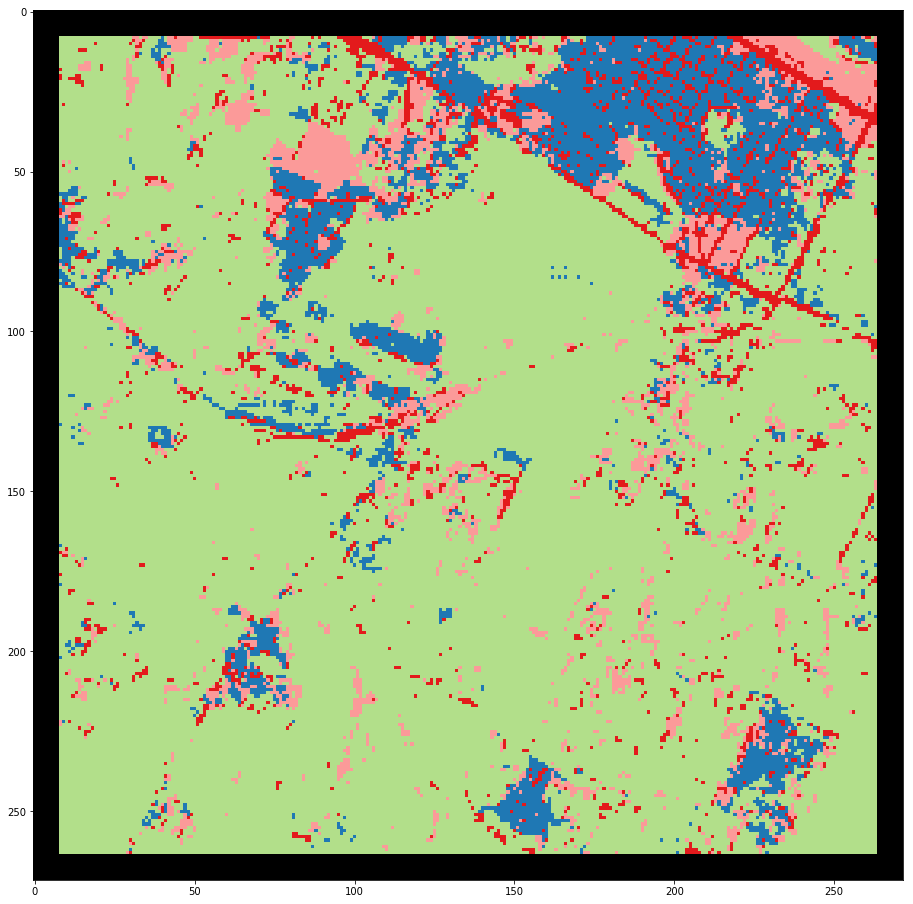

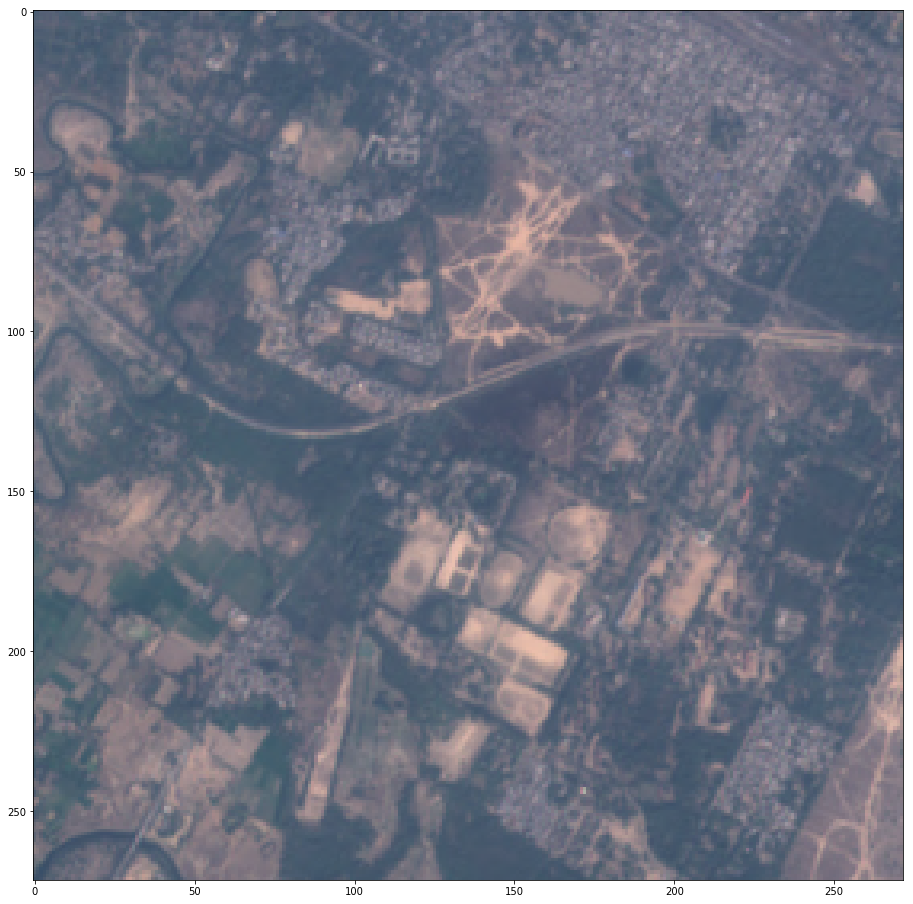

In [9]:
tile_id = 67
result_file = data_path + place + '_tile' + str(tile_id).zfill(3) + '_' + model_id + '_' + image_suffix + '_LULC.tif'

util_rasters.stats_byte_raster(result_file, category_label)

result, geo, prj, cols, rows = util_rasters.load_geotiff(result_file)
result[result==0] = 0
result[result==1] = 1
result[result==2] = 4
result[result==3] = 6

rgb = util_rasters.rgb_lulc_result(result)
fig = plt.figure(figsize=(16,16))
plt.imshow(rgb)
print

img_file = data_path + place + '_tile' + str(tile_id).zfill(3) + '_vir_' + image_suffix + '.tif'
print img_file
util_rasters.show_vir_s2(img_file)